In [8]:
ls

 Volume in drive C is Amadeus
 Volume Serial Number is EE3D-C9E7

 Directory of C:\Users\sfranze\OneDrive - Amadeus Workplace\OC\Proj7\Implementez_un_modele_de_scoring\Data&output

23/02/2023  10:56 am    <DIR>          .
23/02/2023  10:56 am    <DIR>          ..
23/02/2023  10:56 am                 1 .gitignore
23/02/2023  10:37 am       166,133,370 application_train.csv
20/02/2023  10:07 pm             3,537 features.joblib
30/12/2022  10:09 am            37,383 HomeCredit_columns_description.csv
21/02/2023  11:24 pm        27,773,003 input_data.joblib
10/02/2023  11:40 am             5,005 install-pyenv-win.ps1
18/02/2023  05:26 pm           308,540 lightgbm.pkl
19/02/2023  07:03 pm           308,705 lightgbmodel.joblib
19/02/2023  07:03 pm             6,103 standardscaler.joblib
20/02/2023  10:07 pm        66,423,105 test_data.joblib
              10 File(s)    260,998,752 bytes
               2 Dir(s)  209,961,230,336 bytes free


In [6]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
cd data\Projet_Mise_en_prod_home_credit_default_risk

C:\Users\sfranze\OneDrive - Amadeus Workplace\OC\Proj7\Implementez_un_modele_de_scoring\Data&output


In [4]:
ls

 Volume in drive C is Amadeus
 Volume Serial Number is EE3D-C9E7

 Directory of C:\Users\sfranze\OneDrive - Amadeus Workplace\OC\Proj7\Implementez_un_modele_de_scoring\Data&output

23/02/2023  10:56 am    <DIR>          .
23/02/2023  10:56 am    <DIR>          ..
23/02/2023  10:56 am                 1 .gitignore
23/02/2023  10:37 am       166,133,370 application_train.csv
20/02/2023  10:07 pm             3,537 features.joblib
30/12/2022  10:09 am            37,383 HomeCredit_columns_description.csv
21/02/2023  11:24 pm        27,773,003 input_data.joblib
10/02/2023  11:40 am             5,005 install-pyenv-win.ps1
18/02/2023  05:26 pm           308,540 lightgbm.pkl
19/02/2023  07:03 pm           308,705 lightgbmodel.joblib
19/02/2023  07:03 pm             6,103 standardscaler.joblib
20/02/2023  10:07 pm        66,423,105 test_data.joblib
              10 File(s)    260,998,752 bytes
               2 Dir(s)  209,957,822,464 bytes free


In [5]:
#import du dataset de train, que faire avec les autres? 
# ne pas les utiliser pour l'instant

### Import of Train dataset

In [7]:
train_with_target = pd.read_csv('application_train.csv', nrows= None)
train_with_target

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_with_target.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train_with_target.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

### Balance between 0 and 1 clients

In [11]:
train_with_target.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [12]:
good_clients_perc = train_with_target.TARGET.value_counts()[0]/len(train_with_target.TARGET)*100
bad_clients_perc = train_with_target.TARGET.value_counts()[1]/len(train_with_target.TARGET)*100
print (' The % of good client is:',good_clients_perc,'\n','The % of bad client is:', bad_clients_perc)

 The % of good client is: 91.92711805431351 
 The % of bad client is: 8.072881945686495


### Subset of data without target and ID

In [13]:
train = train_with_target.iloc[:,2:]
train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Analysing null data

In [14]:
train.isnull().sum()  # .sort_values(ascending=False)

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 120, dtype: int64

In [15]:
percent_nullval = pd.DataFrame(train_with_target.isnull().sum()/len(train_with_target))   # columns=['columns','percentage']    # .sort_values(ascending=False)
percent_nullval = percent_nullval.reset_index()
percent_nullval.columns = ['columns','percentage']
percent_nullval

,columns,percentage
0,SK_ID_CURR,0.000000
1,TARGET,0.000000
2,NAME_CONTRACT_TYPE,0.000000
3,CODE_GENDER,0.000000
4,FLAG_OWN_CAR,0.000000
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,0.135016
118,AMT_REQ_CREDIT_BUREAU_WEEK,0.135016
119,AMT_REQ_CREDIT_BUREAU_MON,0.135016
120,AMT_REQ_CREDIT_BUREAU_QRT,0.135016


In [16]:
list_cols =  percent_nullval['columns'].tolist()
list_cols

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

### Import description of columns csv to properly analyse them

In [17]:
column_descr = pd.read_csv('HomeCredit_columns_description.csv', nrows= None, encoding= 'ansi')
column_descr

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [18]:
column_descr_subset = column_descr[(column_descr['Table'] == 'application_{train|test}.csv')]
column_descr_subset

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [19]:
column_descr_subset.loc[column_descr_subset['Row'].isin(list_cols)]['Description'].tolist()

['ID of loan in our sample',
 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
 'Identification if loan is cash or revolving',
 'Gender of the client',
 'Flag if the client owns a car',
 'Flag if client owns a house or flat',
 'Number of children the client has',
 'Income of the client',
 'Credit amount of the loan',
 'Loan annuity',
 'For consumer loans it is the price of the goods for which the loan is given',
 'Who was accompanying client when he was applying for the loan',
 'Clients income type (businessman, working, maternity leave,…)',
 'Level of highest education the client achieved',
 'Family status of the client',
 'What is the housing situation of the client (renting, living with parents, ...)',
 'Normalized population of region where client lives (higher number means the client lives in more populated region)',
 "Client's age in days a

In [20]:
percent_nullval["description"] = column_descr_subset.loc[column_descr_subset['Row'].isin(list_cols)]['Description'].tolist()
percent_nullval.sort_values(by = 'percentage', ascending=False)

,columns,percentage,description
76,COMMONAREA_MEDI,0.698723,Normalized information about building where th...
48,COMMONAREA_AVG,0.698723,Normalized information about building where th...
62,COMMONAREA_MODE,0.698723,Normalized information about building where th...
70,NONLIVINGAPARTMENTS_MODE,0.694330,Normalized information about building where th...
56,NONLIVINGAPARTMENTS_AVG,0.694330,Normalized information about building where th...
...,...,...,...
15,NAME_HOUSING_TYPE,0.000000,What is the housing situation of the client (r...
14,NAME_FAMILY_STATUS,0.000000,Family status of the client
13,NAME_EDUCATION_TYPE,0.000000,Level of highest education the client achieved
12,NAME_INCOME_TYPE,0.000000,"Clients income type (businessman, working, mat..."


### Own car analysis

In [21]:
# analyse flag own car with own car age
train.loc[train['FLAG_OWN_CAR']== 'Y']['OWN_CAR_AGE'].isnull().sum() #just 5 on 104578 clients who owns a car has this missing value

5

In [22]:
train.loc[train['FLAG_OWN_CAR']== 'N']['OWN_CAR_AGE'].isnull().sum()   # 100% of own car = NO

202924

### Choosing columns to drop

In [23]:
to_drop = ['ENTRANCES_MEDI',
           'ENTRANCES_MODE',
           'ENTRANCES_AVG',
           'APARTMENTS_MODE',
           'APARTMENTS_MEDI',
           'APARTMENTS_AVG',
           'HOUSETYPE_MODE',
           'TOTALAREA_MODE',
           'HOUSETYPE_MODE',
    'NONLIVINGAREA_MODE',
           'CNT_CHILDREN',
           'NONLIVINGAREA_AVG',
           'NONLIVINGAREA_MEDI',
           'LIVINGAREA_MEDI',
           'LIVINGAREA_MODE',
           'LIVINGAREA_AVG',
           'FLOORSMIN_AVG',
           'FLAG_EMP_PHONE',
           'FLOORSMIN_MEDI',
           'FLOORSMIN_MODE',
           'FLOORSMAX_MEDI',
           'HOUR_APPR_PROCESS_START',
           'NAME_TYPE_SUITE',
           'FLOORSMAX_AVG',
           'FLOORSMAX_MODE',
           'FONDKAPREMONT_MODE',
    'DAYS_LAST_PHONE_CHANGE',
    'YEARS_BEGINEXPLUATATION_MEDI',
           'YEARS_BEGINEXPLUATATION_AVG',
           'YEARS_BEGINEXPLUATATION_MEDI',
           'YEARS_BEGINEXPLUATATION_MODE',
           'TOTALAREA_MODE',
           'EMERGENCYSTATE_MODE',
           'COMMONAREA_MODE',
           'FLAG_DOCUMENT_3',
           'FLAG_DOCUMENT_4',
           'FLAG_DOCUMENT_5',
           'FLAG_DOCUMENT_6',
           'FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8',
           'FLAG_DOCUMENT_9',
           'FLAG_DOCUMENT_10',
           'FLAG_DOCUMENT_11',
           'FLAG_DOCUMENT_12',
           'FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14',
           'FLAG_DOCUMENT_15',
           'FLAG_DOCUMENT_16',
           'FLAG_DOCUMENT_17',
           'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19',
           'FLAG_DOCUMENT_20',
           'FLAG_DOCUMENT_21',
           'COMMONAREA_MEDI',
           'COMMONAREA_AVG',
           'NONLIVINGAPARTMENTS_MEDI',
           'NONLIVINGAPARTMENTS_AVG',
           'NONLIVINGAPARTMENTS_MODE',
           'LIVINGAPARTMENTS_AVG',
           'LIVINGAPARTMENTS_MEDI',
           'LIVINGAPARTMENTS_MODE',
           'YEARS_BUILD_AVG',
           'YEARS_BUILD_MEDI',
           'YEARS_BUILD_MODE',
           'LANDAREA_MEDI',
           'LANDAREA_AVG',
           'BASEMENTAREA_MEDI',
           'BASEMENTAREA_AVG',
           'AMT_GOODS_PRICE',
           'ELEVATORS_AVG',
           'ELEVATORS_MEDI',
           'WALLSMATERIAL_MODE',
           'REGION_RATING_CLIENT_W_CITY',
           'LIVE_REGION_NOT_WORK_REGION',
           'LIVE_CITY_NOT_WORK_CITY',
           'DEF_30_CNT_SOCIAL_CIRCLE',
           'OBS_30_CNT_SOCIAL_CIRCLE',
           'OWN_CAR_AGE'
           ]

In [24]:
train_slim = train.drop(columns=to_drop)
train_slim

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,202500.0,406597.5,24700.5,Working,Secondary / secondary special,Single / not married,...,0.0377,2.0,2.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,270000.0,1293502.5,35698.5,State servant,Higher education,Married,...,0.0128,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,67500.0,135000.0,6750.0,Working,Secondary / secondary special,Single / not married,...,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,135000.0,312682.5,29686.5,Working,Secondary / secondary special,Civil marriage,...,NaN,2.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,121500.0,513000.0,21865.5,Working,Secondary / secondary special,Single / not married,...,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,157500.0,254700.0,27558.0,Working,Secondary / secondary special,Separated,...,0.0094,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,Cash loans,F,N,Y,72000.0,269550.0,12001.5,Pensioner,Secondary / secondary special,Widow,...,0.0592,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,Cash loans,F,N,Y,153000.0,677664.0,29979.0,Working,Higher education,Separated,...,NaN,6.0,0.0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,Cash loans,F,N,Y,171000.0,370107.0,20205.0,Commercial associate,Secondary / secondary special,Married,...,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

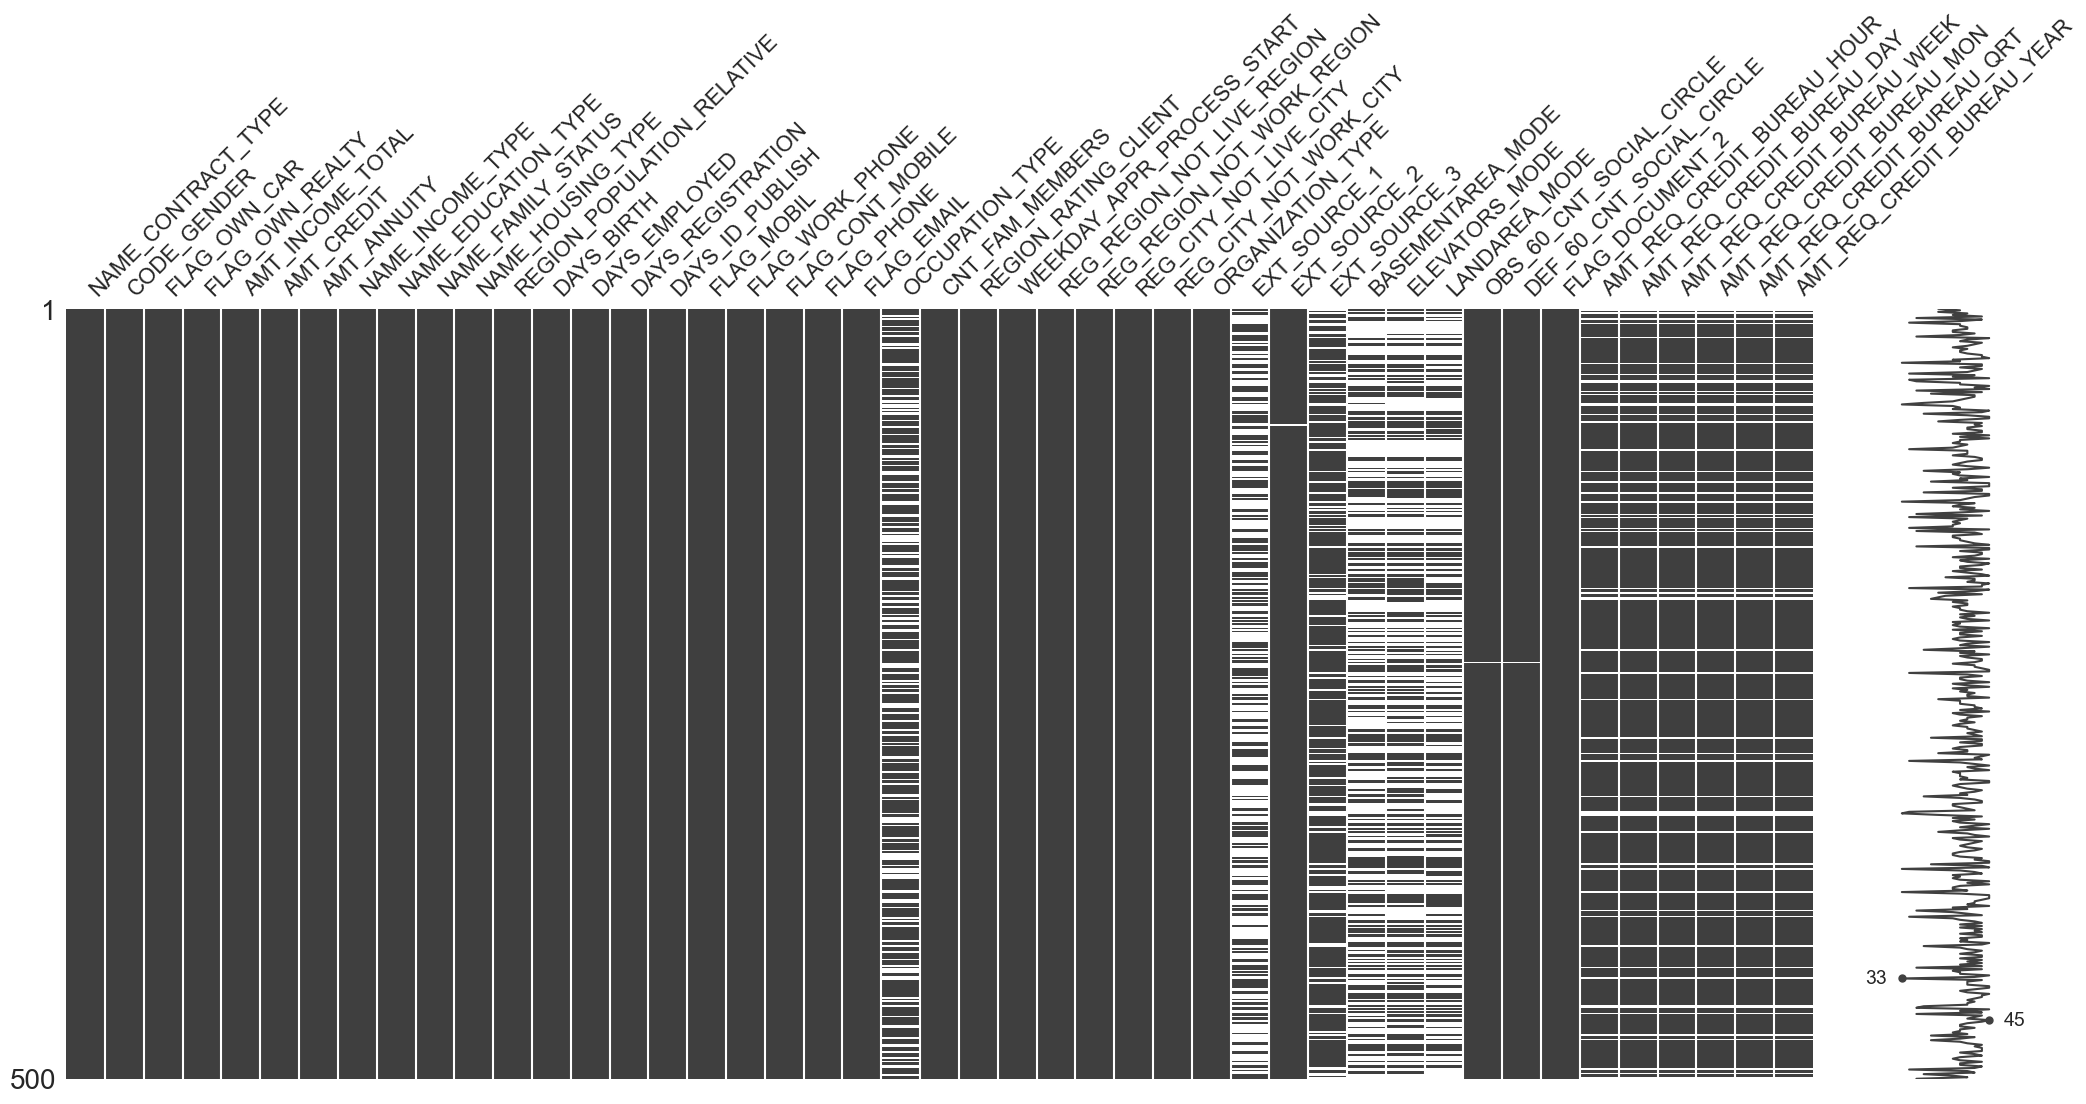

In [25]:
msno.matrix(train_slim.sample(500))

### Correlation between features

In [26]:
corr = train_slim.corr()
corr

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,...,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
AMT_INCOME_TOTAL,1.000000,0.156870,0.191657,0.074796,0.027261,-0.064223,0.027805,0.008506,0.000325,-0.017193,...,-0.003674,-0.013015,-0.013135,-0.001000,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,0.156870,1.000000,0.770138,0.099738,-0.055436,-0.066838,0.009621,-0.006575,0.001436,-0.021085,...,0.002532,0.000239,-0.023767,0.008905,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,0.191657,0.770138,1.000000,0.118429,0.009445,-0.104332,0.038514,0.011268,0.000149,-0.024803,...,0.003621,-0.011731,-0.024001,0.003397,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320
REGION_POPULATION_RELATIVE,0.074796,0.099738,0.118429,1.000000,-0.029582,-0.003980,-0.053820,-0.003993,0.001333,-0.015628,...,-0.060558,-0.010638,0.002404,-0.003040,-0.002225,0.001399,-0.002149,0.078607,-0.001279,0.001003
DAYS_BIRTH,0.027261,-0.055436,0.009445,-0.029582,1.000000,-0.615864,0.331912,0.272691,-0.003084,0.172457,...,0.003800,0.007023,0.001925,-0.001191,0.005285,0.002255,-0.001336,0.001372,-0.011799,-0.071983
DAYS_EMPLOYED,-0.064223,-0.066838,-0.104332,-0.003980,-0.615864,1.000000,-0.210242,-0.272378,0.000818,-0.233972,...,-0.008758,0.005888,0.014211,-0.003090,-0.004735,0.000472,0.003072,-0.034457,0.015345,0.049988
DAYS_REGISTRATION,0.027805,0.009621,0.038514,-0.053820,0.331912,-0.210242,1.000000,0.101896,-0.000100,0.058283,...,0.003354,0.009088,0.004538,-0.004466,-0.002855,-0.000508,-0.001069,-0.011353,-0.001308,-0.024805
DAYS_ID_PUBLISH,0.008506,-0.006575,0.011268,-0.003993,0.272691,-0.272378,0.101896,1.000000,-0.002293,0.045964,...,-0.008026,-0.012874,0.004328,-0.000349,0.004761,-0.000999,-0.001249,-0.009660,-0.006200,-0.035099
FLAG_MOBIL,0.000325,0.001436,0.000149,0.001333,-0.003084,0.000818,-0.000100,-0.002293,1.000000,0.000900,...,-0.000618,0.001067,0.000499,0.000012,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_WORK_PHONE,-0.017193,-0.021085,-0.024803,-0.015628,0.172457,-0.233972,0.058283,0.045964,0.000900,1.000000,...,0.001343,-0.012619,-0.007477,-0.001993,-0.005358,-0.004434,-0.004404,-0.001829,-0.022964,-0.075875


<AxesSubplot:>

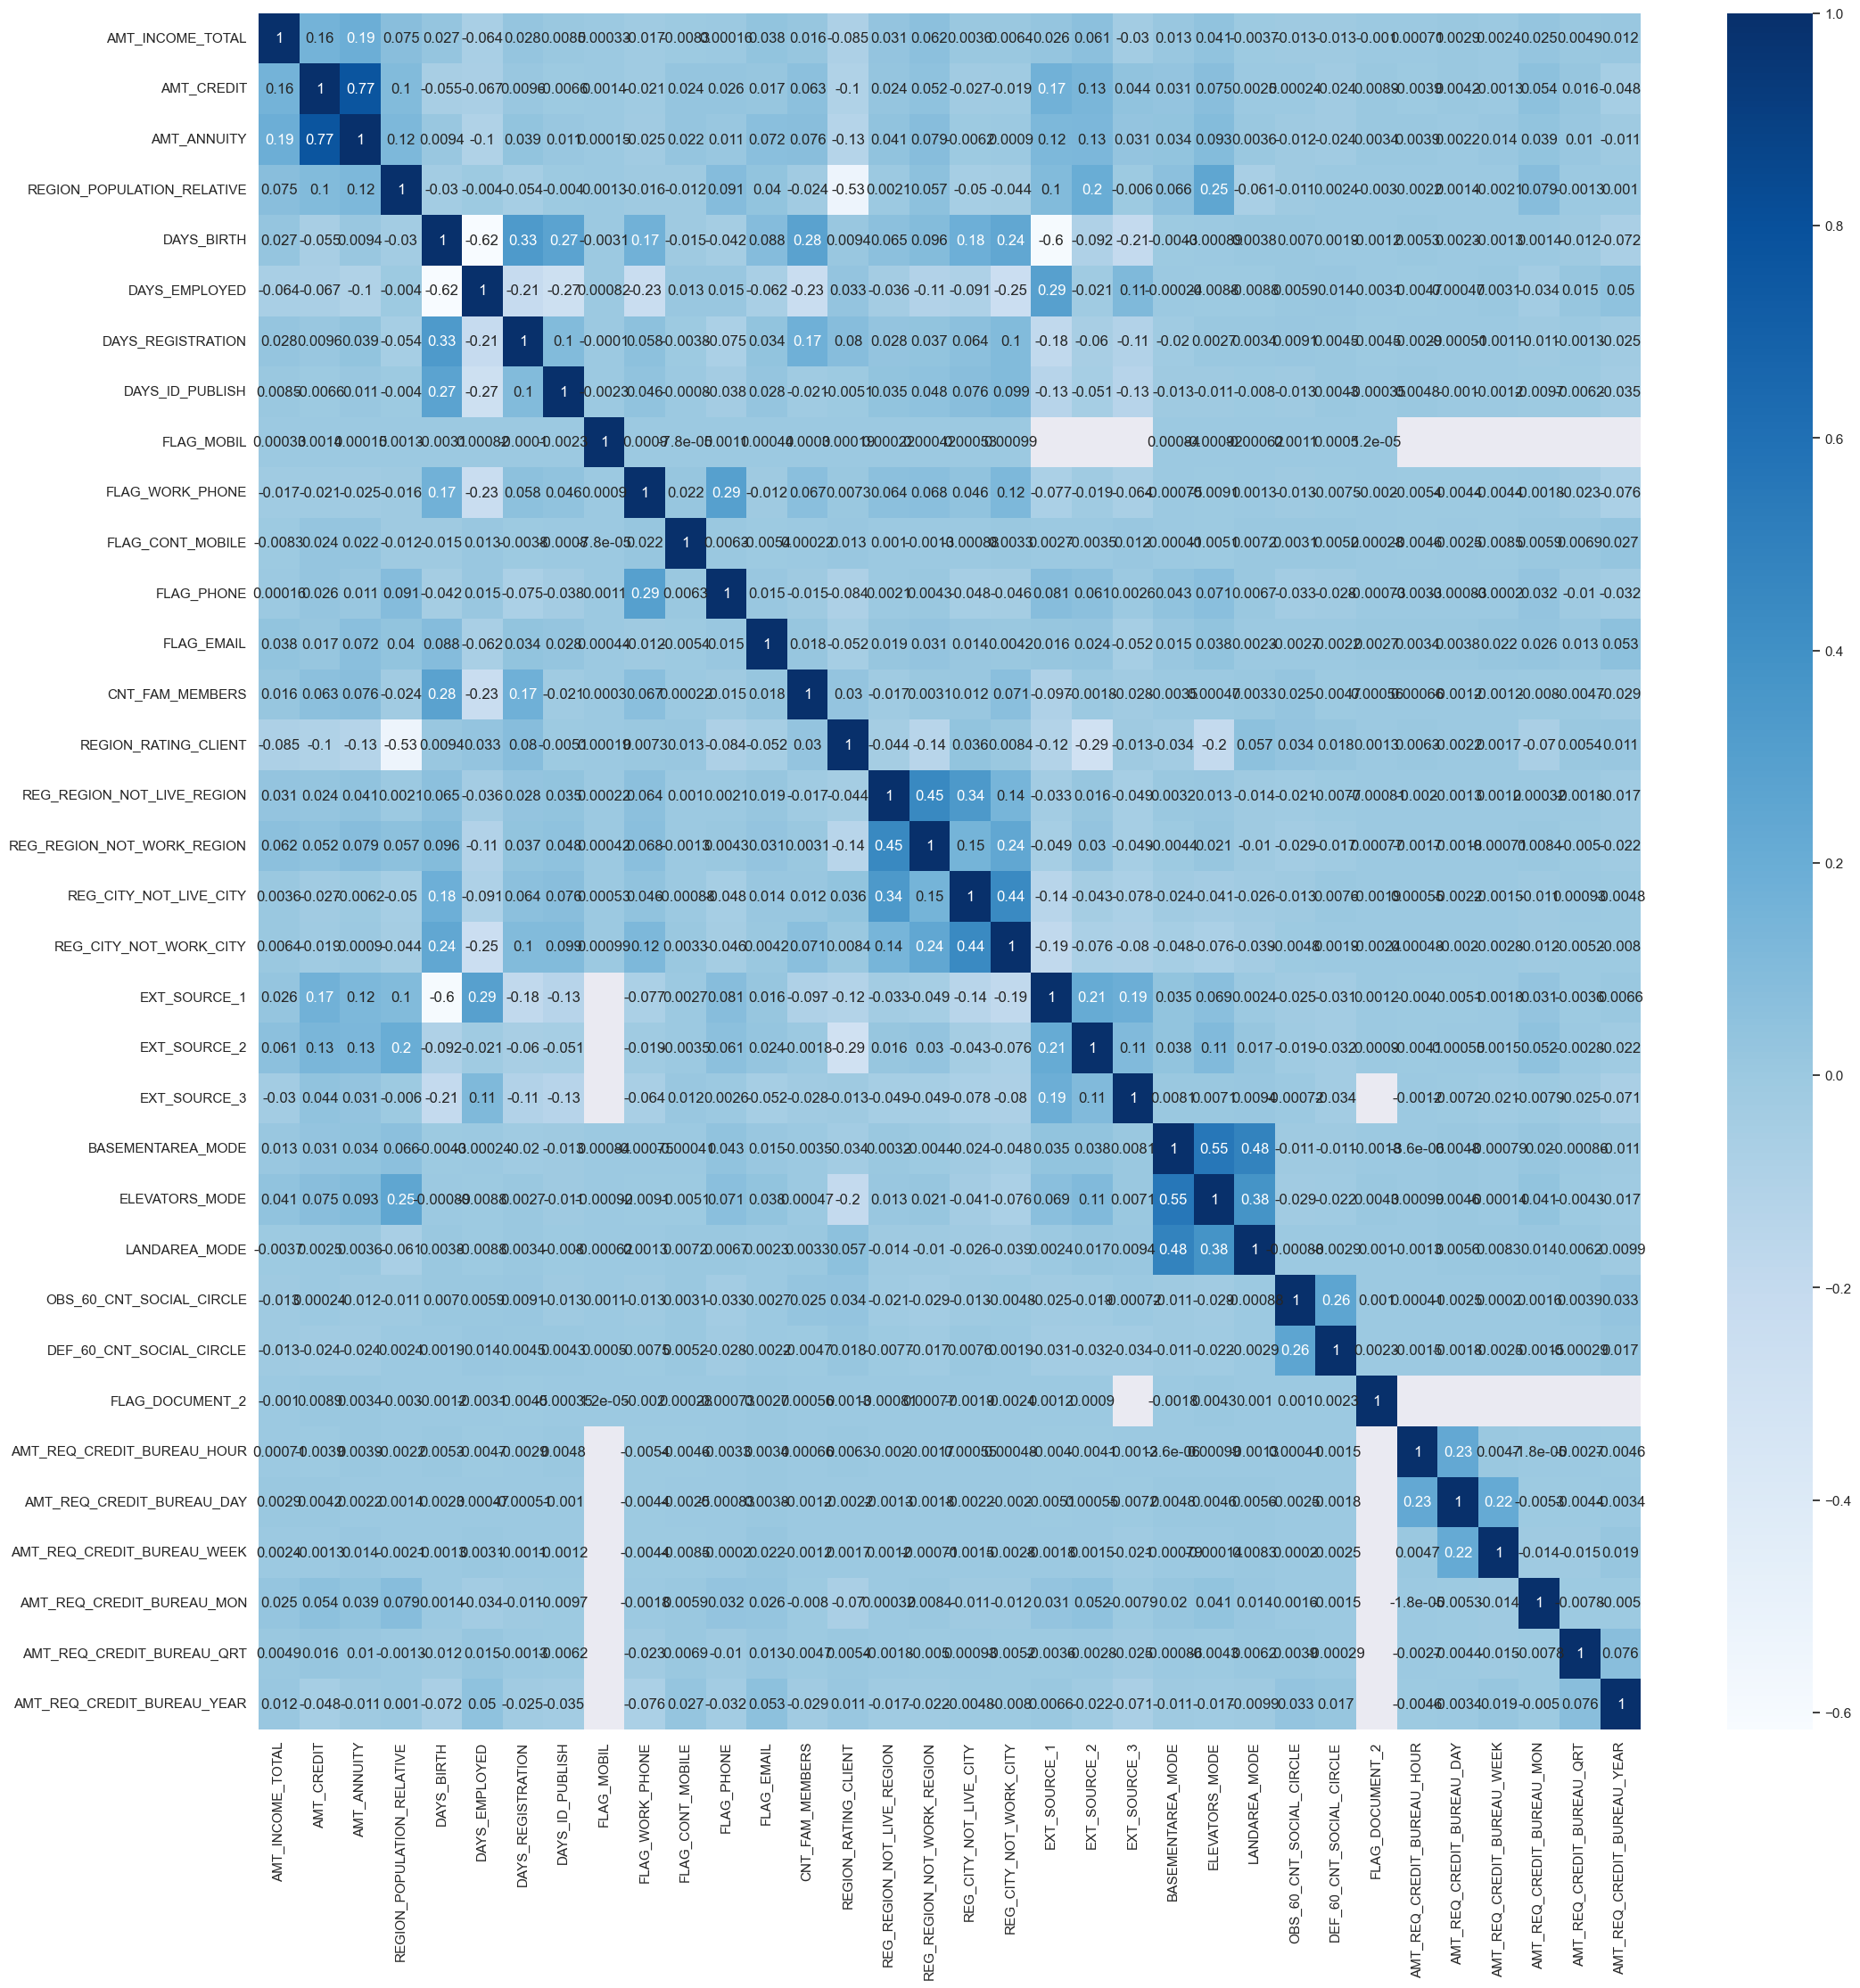

In [27]:
sns.set(rc={'figure.figsize':(25,25)})
sns.heatmap(corr, cmap="Blues", annot=True)

In [28]:
train_slim.isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
OCCUPATION_TYPE                96391
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT               0
WEEKDAY_APPR_PROCESS_START         0
REG_REGION_NOT_LIVE_REGION         0
REG_REGION_NOT_WORK_REGION         0
R

### Substitution of nan with 0 in selected columns

In [29]:
train_slim = train_slim.fillna({'EXT_SOURCE_1':0,
'EXT_SOURCE_2':0,
'EXT_SOURCE_3':0,
'BASEMENTAREA_MODE':0,
'ELEVATORS_MODE':0,
'LANDAREA_MODE':0})

train_slim.isnull().sum()

# 'YEARS_BUILD_MODE':0,
# 'COMMONAREA_MODE':0,
# 'LIVINGAPARTMENTS_MODE':0,
# 'NONLIVINGAPARTMENTS_MODE':0})

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      12
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
FLAG_MOBIL                        0
FLAG_WORK_PHONE                   0
FLAG_CONT_MOBILE                  0
FLAG_PHONE                        0
FLAG_EMAIL                        0
OCCUPATION_TYPE               96391
CNT_FAM_MEMBERS                   2
REGION_RATING_CLIENT              0
WEEKDAY_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION        0
REG_REGION_NOT_WORK_REGION        0
REG_CITY_NOT_LIVE_CITY      

### Substitution of other columns nans with mode

In [30]:
train_slim['CNT_FAM_MEMBERS'] = train_slim['CNT_FAM_MEMBERS'].fillna(train_slim['CNT_FAM_MEMBERS'].mode()[0])
train_slim['OCCUPATION_TYPE'] = train_slim['OCCUPATION_TYPE'].fillna(train_slim['OCCUPATION_TYPE'].mode()[0])
train_slim['OBS_60_CNT_SOCIAL_CIRCLE'] = train_slim['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(train_slim['OBS_60_CNT_SOCIAL_CIRCLE'].mode()[0])
train_slim['DEF_60_CNT_SOCIAL_CIRCLE'] = train_slim['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(train_slim['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0])
train_slim[['AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']] = train_slim[['AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].fillna(train_slim[['AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].median())

In [31]:
train_slim.isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
FLAG_MOBIL                    0
FLAG_WORK_PHONE               0
FLAG_CONT_MOBILE              0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE               0
CNT_FAM_MEMBERS               0
REGION_RATING_CLIENT          0
WEEKDAY_APPR_PROCESS_START    0
REG_REGION_NOT_LIVE_REGION    0
REG_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY        0
REG_CITY_NOT_WORK_CITY        0
ORGANIZATION_TYPE             0
EXT_SOURCE_1                  0
EXT_SOUR

### Application of kaggle Kernel

In [32]:
# extraction of kernel functions to use as first steps

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv
# edit: modify this function to apply it at train dataset then eventually re use it when I need to split it in train and test , not in the first moment
def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    # train_df = pd.read_csv('application_train.csv', nrows= num_rows)
    df = train_slim   # change name of assigned df based on needs, train_with_target is the untouched one
    
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    # df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

In [33]:
train_feat_eng = application_train()

Train samples: 307511


In [34]:
# applicatin partie modeles, diviser le dataset en train et test et validation 

# recherche des hyperparametres par exemple avec grid search cv, faire la cross validation 

# light gbm a tester, regression logistique, random forest
train_feat_eng.drop(['DAYS_EMPLOYED','DAYS_BIRTH','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT'], inplace=True, axis=1)

In [35]:
train_feat_eng.isnull().sum()   # .describe()

CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
REGION_POPULATION_RELATIVE        0
DAYS_REGISTRATION                 0
                              ...  
DAYS_EMPLOYED_PERC            55374
INCOME_CREDIT_PERC                0
INCOME_PER_PERSON                 0
ANNUITY_INCOME_PERC               0
PAYMENT_RATE                      0
Length: 146, dtype: int64

In [36]:
# to further explore this choice
# train_feat_eng['DAYS_EMPLOYED'] = train_feat_eng['DAYS_EMPLOYED'].fillna(train_feat_eng['DAYS_EMPLOYED'].mode()[0])
train_feat_eng['DAYS_EMPLOYED_PERC'] = train_feat_eng['DAYS_EMPLOYED_PERC'].fillna(train_feat_eng['DAYS_EMPLOYED_PERC'].median())

In [37]:
train_feat_eng.shape

(307511, 146)

### Separation in X and y set, train-test-split

In [38]:
#! pip install imblearn

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

In [40]:
X = train_feat_eng # .iloc[:,2:] not necessary now because I've already removed the target at the beginning
y = train_with_target['TARGET']
features_cols = X.columns
X

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,0,0,0.018801,-3648.0,-2120,1,0,1,1,...,0,0,0,0,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,0,1,0.003541,-1186.0,-291,1,0,1,1,...,0,0,0,0,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,0,1,0,0.010032,-4260.0,-2531,1,1,1,1,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,1,0,0,0.008019,-9833.0,-2437,1,0,1,0,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,0,0,0,0.028663,-4311.0,-3458,1,0,1,0,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0.032561,-8456.0,-1982,1,0,1,0,...,0,0,0,0,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,1,0,0,0.025164,-4388.0,-4090,1,0,1,1,...,0,0,0,0,1,0.118733,0.267112,72000.0,0.166687,0.044524
307508,1,0,0,0.005002,-6737.0,-5150,1,0,1,0,...,0,0,0,0,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,1,0,0,0.005313,-2562.0,-931,1,0,1,0,...,0,0,0,0,0,0.400134,0.462029,85500.0,0.118158,0.054592


### Select k best features directly from X and Y

In [41]:
# Create and fit selector
selectorr = SelectKBest(f_classif, k=90)
selectorr.fit(X,y)
# Get columns to keep and create new dataframe with those only
cols = selectorr.get_support(indices=True)
X_new = X.iloc[:,cols]
X_new

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,0,0,0.018801,-3648.0,-2120,0,1,2,0,...,0,0,0,0,0,0,0.067329,202500.0,0.121978,0.060749
1,1,0,1,0.003541,-1186.0,-291,0,1,1,0,...,0,0,0,0,0,0,0.070862,135000.0,0.132217,0.027598
2,0,1,0,0.010032,-4260.0,-2531,1,1,2,0,...,0,0,0,0,0,0,0.011814,67500.0,0.100000,0.050000
3,1,0,0,0.008019,-9833.0,-2437,0,0,2,0,...,0,0,0,0,0,0,0.159905,67500.0,0.219900,0.094941
4,0,0,0,0.028663,-4311.0,-3458,0,0,2,0,...,0,0,0,0,0,0,0.152418,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0.032561,-8456.0,-1982,0,0,1,0,...,0,0,0,0,0,0,0.025303,157500.0,0.174971,0.108198
307507,1,0,0,0.025164,-4388.0,-4090,0,1,2,0,...,0,0,0,0,0,1,0.118733,72000.0,0.166687,0.044524
307508,1,0,0,0.005002,-6737.0,-5150,0,0,3,0,...,0,0,0,0,0,0,0.529266,153000.0,0.195941,0.044239
307509,1,0,0,0.005313,-2562.0,-931,0,0,2,0,...,0,0,0,0,0,0,0.400134,85500.0,0.118158,0.054592


In [42]:
# X_new = SelectKBest(mutual_info_classif, k = 80).fit_transform(X,y)
features_colss = X_new.columns
X_new.shape

(307511, 90)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y,
                                                    test_size = 0.3,
                                                    random_state = 6)

In [44]:
X_train.shape, X_test.shape

((215257, 90), (92254, 90))

### Scaling data with StandardScaler

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.71977446, -0.71987857,  1.50367051, ..., -0.02935865,
         0.46189274, -1.1622507 ],
       [ 0.71977446, -0.71987857, -0.66503931, ...,  1.17769075,
        -1.24375697, -0.51070176],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.37135598,
        -0.85292657,  0.05408736],
       ...,
       [ 0.71977446,  1.38912316, -0.66503931, ..., -0.1299461 ,
        -0.30286775, -0.23775181],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.43170845,
         1.26064762, -0.10699927],
       [ 0.71977446, -0.71987857,  1.50367051, ..., -0.49206092,
        -1.45026956, -0.6451812 ]])

In [46]:
X_test_scaled

array([[ 0.71977446, -0.71987857, -0.66503931, ..., -0.16347525,
        -0.60612794,  1.70989857],
       [ 0.71977446,  1.38912316, -0.66503931, ..., -0.00924116,
        -0.50997375, -0.74657241],
       [ 0.71977446, -0.71987857, -0.66503931, ...,  0.17181625,
        -0.08536408, -0.24959748],
       ...,
       [ 0.71977446, -0.71987857, -0.66503931, ...,  0.81557593,
        -0.669904  ,  1.14618343],
       [ 0.71977446,  1.38912316,  1.50367051, ..., -0.43170845,
         1.17868337, -1.08875262],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.43170845,
        -1.2968134 , -0.16517623]])

### MODEL SELECTION smote + model inside pipeline to handle imbalanced dataset

### Logistic regression

In [78]:
# remember to add time calculations for each model

In [79]:
# parameter grid
params1 = {'verbose': [2],
    'classification__penalty' : ['l1', 'l2'],
           'classification__C' : np.logspace(-4, 4, 20),
           'classification__solver' : ['liblinear']}

    #   { 'classification__penalty' : ['l1','l2'],        'classification__C'  : np.logspace(-3,3,7),       'classification__solver'  : ['saga','lbfgs', 'liblinear']  }

In [80]:
logisticmodel = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.20)),
    ('classification', LogisticRegression())
])

grid1 = GridSearchCV(logisticmodel, param_grid = params1, scoring = 'roc_auc')
grid1.fit(X_train_scaled, y_train)

[Pipeline] .......... (step 1 of 2) Processing sampling, total=   5.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=   0.8s


KeyboardInterrupt: 

In [ ]:
logisticmodel.get_params().keys()

In [ ]:
grid1.best_params_

#### Logistic Regression score

In [ ]:
grid1.best_score_

In [ ]:
grid1.best_estimator_.score(X_test_scaled,y_test)

### Lightgbm

In [81]:
params2 = {'verbose':[2],
    'classification__learning_rate': [0.2,0.3,0.4],
           'classification__max_depth': [1,3,5],
           'classification__n_estimators':[100,300],
           'classification__num_leaves': [20,31],
           'classification__subsample': [0.4,0.8]}

In [82]:
lightgbmodel = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.25)),    # rajouter ............... SMOTE(sampling_strategy=0.20) sinon trop violent reequilibre
    ('classification', lgb.LGBMClassifier())
])

grid2 = GridSearchCV(lightgbmodel, params2, scoring = 'roc_auc')
grid2.fit(X_train_scaled, y_train)

[Pipeline] .......... (step 1 of 2) Processing sampling, total=   5.7s
[Pipeline] .... (step 2 of 2) Processing classification, total=   3.1s
[Pipeline] .......... (step 1 of 2) Processing sampling, total=   5.7s
[Pipeline] .... (step 2 of 2) Processing classification, total=   1.8s
[Pipeline] .......... (step 1 of 2) Processing sampling, total=   4.7s
[Pipeline] .... (step 2 of 2) Processing classification, total=   2.6s
[Pipeline] .......... (step 1 of 2) Processing sampling, total=   4.3s
[Pipeline] .... (step 2 of 2) Processing classification, total=   2.5s
[Pipeline] .......... (step 1 of 2) Processing sampling, total=   4.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=   2.2s
[Pipeline] .......... (step 1 of 2) Processing sampling, total=   7.0s
[Pipeline] .... (step 2 of 2) Processing classification, total=   2.2s
[Pipeline] .......... (step 1 of 2) Processing sampling, total=   5.5s
[Pipeline] .... (step 2 of 2) Processing classification, total=   2.0s
[Pipel

GridSearchCV(estimator=Pipeline(steps=[('sampling',
                                        SMOTE(sampling_strategy=0.25)),
                                       ('classification', LGBMClassifier())]),
             param_grid={'classification__learning_rate': [0.2, 0.3, 0.4],
                         'classification__max_depth': [1, 3, 5],
                         'classification__n_estimators': [100, 300],
                         'classification__num_leaves': [20, 31],
                         'classification__subsample': [0.4, 0.8],
                         'verbose': [2]},
             scoring='roc_auc')

In [83]:
lightgbmodel.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'sampling', 'classification', 'sampling__k_neighbors', 'sampling__n_jobs', 'sampling__random_state', 'sampling__sampling_strategy', 'classification__boosting_type', 'classification__class_weight', 'classification__colsample_bytree', 'classification__importance_type', 'classification__learning_rate', 'classification__max_depth', 'classification__min_child_samples', 'classification__min_child_weight', 'classification__min_split_gain', 'classification__n_estimators', 'classification__n_jobs', 'classification__num_leaves', 'classification__objective', 'classification__random_state', 'classification__reg_alpha', 'classification__reg_lambda', 'classification__silent', 'classification__subsample', 'classification__subsample_for_bin', 'classification__subsample_freq'])

In [84]:
grid2.best_params_

{'classification__learning_rate': 0.2,
 'classification__max_depth': 3,
 'classification__n_estimators': 300,
 'classification__num_leaves': 20,
 'classification__subsample': 0.4,
 'verbose': 2}

In [85]:
# grid2.predict(X_train_scaled)

#### Predict proba light gbm

In [86]:
grid2.predict_proba(X_test_scaled)

array([[0.79240982, 0.20759018],
       [0.92180291, 0.07819709],
       [0.92494593, 0.07505407],
       ...,
       [0.9122985 , 0.0877015 ],
       [0.94488397, 0.05511603],
       [0.97551271, 0.02448729]])

In [87]:
# voir pouir chaque seuil quei va me rembourser, avoir un colonne par seuil, voir d apres le proa qui va rembourser ou pas , arriver a voir le nombre de faux positif et le nombre de faux negatif, appliquer un coefficient , calculer un  cout pour chaque seuil, et voir quel seuil cout le moin

#### Light GBM Score

In [88]:
grid2.best_score_

0.7565222478622995

In [89]:
grid2.best_estimator_.score(X_test_scaled,y_test)

0.920285299282416

### Random forest

In [53]:
# Number of trees in random forest
n_estimators = [400]   # int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,5]
# Minimum number of samples required to split a node
min_samples_split = [100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [200]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
params3 = {'classification__n_estimators': n_estimators,
           'classification__max_depth': max_depth,
           'classification__min_samples_split': min_samples_split,
           'classification__min_samples_leaf': min_samples_leaf,
           'classification__bootstrap': bootstrap,
           'classification__verbose':[2],
           'classification__n_jobs':[-1],
           'classification__warm_start':[True]}

In [54]:
randformodel = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.20)),
    ('classification', RandomForestClassifier())
])

grid3 = GridSearchCV(randformodel, params3, scoring = 'roc_auc',verbose= 3)
grid3.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 1/5] END classification__bootstrap=True, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.708 total time=  27.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   16.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.3s finished


[CV 2/5] END classification__bootstrap=True, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.717 total time=  22.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 3/5] END classification__bootstrap=True, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.704 total time=  23.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   17.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 4/5] END classification__bootstrap=True, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.703 total time=  23.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.5s finished


[CV 5/5] END classification__bootstrap=True, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.715 total time=  25.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.5s finished


[CV 1/5] END classification__bootstrap=True, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.719 total time=  45.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   36.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 2/5] END classification__bootstrap=True, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.726 total time=  42.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   36.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 3/5] END classification__bootstrap=True, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.717 total time=  41.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   36.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 4/5] END classification__bootstrap=True, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.713 total time=  41.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   35.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 5/5] END classification__bootstrap=True, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.722 total time=  41.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 1/5] END classification__bootstrap=False, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.707 total time=  26.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 2/5] END classification__bootstrap=False, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.715 total time=  27.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 3/5] END classification__bootstrap=False, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.705 total time=  27.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 4/5] END classification__bootstrap=False, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.702 total time=  27.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 5/5] END classification__bootstrap=False, classification__max_depth=2, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.711 total time=  28.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   49.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.5s finished


[CV 1/5] END classification__bootstrap=False, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.719 total time=  55.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   51.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.6s finished


[CV 2/5] END classification__bootstrap=False, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.723 total time=  57.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   49.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 3/5] END classification__bootstrap=False, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.716 total time=  56.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   47.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 4/5] END classification__bootstrap=False, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.713 total time=  53.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   45.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.4s finished


[CV 5/5] END classification__bootstrap=False, classification__max_depth=5, classification__min_samples_leaf=200, classification__min_samples_split=100, classification__n_estimators=400, classification__n_jobs=-1, classification__verbose=2, classification__warm_start=True;, score=0.722 total time=  51.1s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s


building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.7s


building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400building tree 189 of 400

building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   39.8s


building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400building tree 372 of 400

building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   45.2s finished


GridSearchCV(estimator=Pipeline(steps=[('sampling',
                                        SMOTE(sampling_strategy=0.2)),
                                       ('classification',
                                        RandomForestClassifier())]),
             param_grid={'classification__bootstrap': [True, False],
                         'classification__max_depth': [2, 5],
                         'classification__min_samples_leaf': [200],
                         'classification__min_samples_split': [100],
                         'classification__n_estimators': [400],
                         'classification__n_jobs': [-1],
                         'classification__verbose': [2],
                         'classification__warm_start': [True]},
             scoring='roc_auc', verbose=3)

In [55]:
randformodel.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sampling', 'classification', 'sampling__k_neighbors', 'sampling__n_jobs', 'sampling__random_state', 'sampling__sampling_strategy', 'classification__bootstrap', 'classification__ccp_alpha', 'classification__class_weight', 'classification__criterion', 'classification__max_depth', 'classification__max_features', 'classification__max_leaf_nodes', 'classification__max_samples', 'classification__min_impurity_decrease', 'classification__min_samples_leaf', 'classification__min_samples_split', 'classification__min_weight_fraction_leaf', 'classification__n_estimators', 'classification__n_jobs', 'classification__oob_score', 'classification__random_state', 'classification__verbose', 'classification__warm_start'])

In [56]:
grid3.best_params_

{'classification__bootstrap': True,
 'classification__max_depth': 5,
 'classification__min_samples_leaf': 200,
 'classification__min_samples_split': 100,
 'classification__n_estimators': 400,
 'classification__n_jobs': -1,
 'classification__verbose': 2,
 'classification__warm_start': True}

#### Random Forest score

In [57]:
grid3.best_score_

0.7195405215377733

In [58]:
grid3.best_estimator_.score(X_test_scaled,y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.8s finished


0.92015522362174

#### RF Predict proba

In [ ]:
grid3.predict_proba(X_test)

### MODEL CHOOSED: LIGHT GBM

#### (not necessary) Re running pipeline with LightGBM best grid parameters, and scaler too
not necessary as I need to export 2 objects, the standard scaler and the model needs to be exported separately

In [56]:
pipe_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('sampling', SMOTE(sampling_strategy=0.20)),
    ('classification', lgb.LGBMClassifier(**grid2.best_params_))
])

In [57]:
pipe_lgbm.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: classification__num_leaves
[LightGBM] [Warning] Unknown parameter: classification__learning_rate
[LightGBM] [Warning] Unknown parameter: classification__max_depth
[LightGBM] [Warning] Unknown parameter: classification__n_estimators
[LightGBM] [Warning] Unknown parameter: classification__subsample
[LightGBM] [Warning] Unknown parameter: classification__num_leaves
[LightGBM] [Warning] Unknown parameter: classification__learning_rate
[LightGBM] [Warning] Unknown parameter: classification__max_depth
[LightGBM] [Warning] Unknown parameter: classification__n_estimators
[LightGBM] [Warning] Unknown parameter: classification__subsample
[LightGBM] [Info] Number of positive: 197822, number of negative: 197822
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.917812
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.653941
[LightGBM] [Debug] init for col-wise cost 0.028652 seconds, init for row-wise cost 0.068219 se

Pipeline(steps=[('scaler', StandardScaler()), ('sampling', SMOTE()),
                ('classification',
                 LGBMClassifier(classification__learning_rate=0.3,
                                classification__max_depth=3,
                                classification__n_estimators=300,
                                classification__num_leaves=20,
                                classification__subsample=0.4, verbose=2))])

In [72]:
pipe_lgbm.score(X_test,y_test)

NameError: name 'pipe_lgbm' is not defined

### Run de SMOTE et Light GBM sans passer par la pipeline et le Grid Search CV

In [47]:
oversample = SMOTE(sampling_strategy=0.30)

In [48]:
X_train_smote,y_train_smote = oversample.fit_resample(X_train_scaled, y_train)

In [49]:
from collections import Counter
# summarize the new class distribution
counter = Counter(y_train_smote)
print(counter)

Counter({0: 197798, 1: 59339})


In [52]:
grid2.best_params_

In [53]:
light_best_params = {'learning_rate': 0.3,
                     'max_depth': 3,
                     'n_estimators': 300,
                     'num_leaves': 20,
                     'subsample': 0.8,
                     'verbose': 2,
                     'metric':'auc'}

In [54]:
light_for_shap = lgb.LGBMClassifier(**light_best_params)

[LightGBM] [Info] Number of positive: 59339, number of negative: 197798
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.925144
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.725397
[LightGBM] [Debug] init for col-wise cost 0.044346 seconds, init for row-wise cost 0.070387 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 12355
[LightGBM] [Info] Number of data points in the train set: 257137, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230768 -> initscore=-1.203980
[LightGBM] [Info] Start training from score -1.203980
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[Ligh

LGBMClassifier(learning_rate=0.3, max_depth=3, metric='auc', n_estimators=300,
               num_leaves=20, subsample=0.8, verbose=2)

In [55]:
light_for_shap.fit(X_train_smote, y_train_smote)

NameError: name 'y_pred' is not defined

In [69]:
# see for curiosity the result
from sklearn import metrics

accuracy = metrics.roc_auc_score(y_test, y_pred)

print(accuracy)

array([[2.22044605e-16, 1.00000000e+00],
       [6.66133815e-16, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       ...,
       [3.33066907e-15, 1.00000000e+00],
       [6.66133815e-16, 1.00000000e+00],
       [2.22044605e-16, 1.00000000e+00]])

### Exporting lightgbm for Fast API in pickle

In [267]:
list_col_reduced = X_train.columns.values.tolist()

In [279]:
for i in list_col_reduced:
    print(i, '= data', [str(i)])

CODE_GENDER = data ['CODE_GENDER']
FLAG_OWN_CAR = data ['FLAG_OWN_CAR']
FLAG_OWN_REALTY = data ['FLAG_OWN_REALTY']
REGION_POPULATION_RELATIVE = data ['REGION_POPULATION_RELATIVE']
DAYS_REGISTRATION = data ['DAYS_REGISTRATION']
DAYS_ID_PUBLISH = data ['DAYS_ID_PUBLISH']
FLAG_WORK_PHONE = data ['FLAG_WORK_PHONE']
FLAG_PHONE = data ['FLAG_PHONE']
REGION_RATING_CLIENT = data ['REGION_RATING_CLIENT']
REG_REGION_NOT_LIVE_REGION = data ['REG_REGION_NOT_LIVE_REGION']
REG_REGION_NOT_WORK_REGION = data ['REG_REGION_NOT_WORK_REGION']
REG_CITY_NOT_LIVE_CITY = data ['REG_CITY_NOT_LIVE_CITY']
REG_CITY_NOT_WORK_CITY = data ['REG_CITY_NOT_WORK_CITY']
EXT_SOURCE_1 = data ['EXT_SOURCE_1']
EXT_SOURCE_2 = data ['EXT_SOURCE_2']
EXT_SOURCE_3 = data ['EXT_SOURCE_3']
BASEMENTAREA_MODE = data ['BASEMENTAREA_MODE']
ELEVATORS_MODE = data ['ELEVATORS_MODE']
LANDAREA_MODE = data ['LANDAREA_MODE']
OBS_60_CNT_SOCIAL_CIRCLE = data ['OBS_60_CNT_SOCIAL_CIRCLE']
DEF_60_CNT_SOCIAL_CIRCLE = data ['DEF_60_CNT_SOCIAL_CIRCLE

In [256]:
dict_xtrain = X_train.dtypes.to_dict()
for x,k in dict_xtrain.items():
    dict_xtrain[x]= str(k)
    print("{0}: {1}".format(x.replace(" ", ""), k))

CODE_GENDER: int64
FLAG_OWN_CAR: int64
FLAG_OWN_REALTY: int64
REGION_POPULATION_RELATIVE: float64
DAYS_REGISTRATION: float64
DAYS_ID_PUBLISH: int64
FLAG_WORK_PHONE: int64
FLAG_PHONE: int64
REGION_RATING_CLIENT: int64
REG_REGION_NOT_LIVE_REGION: int64
REG_REGION_NOT_WORK_REGION: int64
REG_CITY_NOT_LIVE_CITY: int64
REG_CITY_NOT_WORK_CITY: int64
EXT_SOURCE_1: float64
EXT_SOURCE_2: float64
EXT_SOURCE_3: float64
BASEMENTAREA_MODE: float64
ELEVATORS_MODE: float64
LANDAREA_MODE: float64
OBS_60_CNT_SOCIAL_CIRCLE: float64
DEF_60_CNT_SOCIAL_CIRCLE: float64
FLAG_DOCUMENT_2: int64
AMT_REQ_CREDIT_BUREAU_MON: float64
AMT_REQ_CREDIT_BUREAU_QRT: float64
AMT_REQ_CREDIT_BUREAU_YEAR: float64
NAME_CONTRACT_TYPE_Cashloans: uint8
NAME_CONTRACT_TYPE_Revolvingloans: uint8
NAME_INCOME_TYPE_Commercialassociate: uint8
NAME_INCOME_TYPE_Maternityleave: uint8
NAME_INCOME_TYPE_Pensioner: uint8
NAME_INCOME_TYPE_Stateservant: uint8
NAME_INCOME_TYPE_Unemployed: uint8
NAME_INCOME_TYPE_Working: uint8
NAME_EDUCATION_TYPE_

In [154]:

pd.DataFrame(X_train.dtypes).values

array([[dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('int64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('int64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('float64')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],
       [dtype('uint8')],

In [128]:
ls

 Volume in drive C is Amadeus
 Volume Serial Number is EE3D-C9E7

 Directory of C:\Users\sfranze\OneDrive - Amadeus Workplace\OC\Proj7\Implementez_un_modele_de_scoring\data\Projet_Mise_en_prod_home_credit_default_risk

18/02/2023  05:26 pm    <DIR>          .
18/02/2023  05:26 pm    <DIR>          ..
30/12/2022  10:09 am       166,133,370 application_train.csv
30/12/2022  10:09 am            37,383 HomeCredit_columns_description.csv
10/02/2023  11:40 am             5,005 install-pyenv-win.ps1
18/02/2023  05:26 pm           308,540 lightgbm.pkl
24/01/2023  06:57 am        11,525,288 lightgbm_pipeline.joblib
16/02/2023  04:28 pm           308,269 lightgbmodel.joblib
18/02/2023  05:12 pm    <DIR>          MlflowLightgbm
16/02/2023  04:28 pm             6,103 standardscaler.joblib
               7 File(s)    178,323,958 bytes
               3 Dir(s)  218,221,027,328 bytes free


In [127]:
import pickle
pickle_out = open("lightgbm.pkl", "wb")
pickle.dump(light_for_shap,pickle_out)
pickle_out.close()

In [121]:
light_for_shap.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [54]:
light_for_shap.score(X_test_scaled,y_test)

0.920122704706571

In [55]:
light_for_shap.predict_proba(X_test)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

### Developpement fonction Score metier

In [70]:
df_proba = pd.DataFrame(light_for_shap.predict_proba(X_test_scaled))


array([[0.87146514, 0.12853486],
       [0.91446638, 0.08553362],
       [0.94241237, 0.05758763],
       ...,
       [0.90305252, 0.09694748],
       [0.9465026 , 0.0534974 ],
       [0.97503365, 0.02496635]])

In [71]:
df_proba = pd.DataFrame(grid2.predict_proba(X_test_scaled))


In [72]:
df_proba.columns = ['zero','one']

,0,1
0,0.871465,0.128535
1,0.914466,0.085534
2,0.942412,0.057588
3,0.969372,0.030628
4,0.930900,0.069100
...,...,...
92249,0.988691,0.011309
92250,0.915234,0.084766
92251,0.903053,0.096947
92252,0.946503,0.053497


In [73]:
df_proba['truth'] = y_test.values
df_proba

In [74]:
def type_Decision(x,seuil):
    if x['zero'] > seuil and x['truth'] ==0:
        return 0
    if x['zero'] > seuil and x['truth'] ==1:
        return 10
    if x['zero'] <= seuil and x['truth'] ==0:
        return 1
    if x['zero'] <= seuil and x['truth'] ==1:
        return 0

,zero,one,truth
0,0.871465,0.128535,0
1,0.914466,0.085534,0
2,0.942412,0.057588,0
3,0.969372,0.030628,0
4,0.930900,0.069100,0
...,...,...,...
92249,0.988691,0.011309,0
92250,0.915234,0.084766,0
92251,0.903053,0.096947,0
92252,0.946503,0.053497,1


In [75]:
df_proba['cout_0.05']=df_proba.apply(lambda x: type_Decision(x,0.05),axis=1)
df_proba['cout_0.1']=df_proba.apply(lambda x: type_Decision(x,0.1),axis=1)
df_proba['cout_0.15']=df_proba.apply(lambda x: type_Decision(x,0.15),axis=1)
df_proba['cout_0.2']=df_proba.apply(lambda x: type_Decision(x,0.2),axis=1)
df_proba['cout_0.25']=df_proba.apply(lambda x: type_Decision(x,0.25),axis=1)
df_proba['cout_0.3']=df_proba.apply(lambda x: type_Decision(x,0.3),axis=1)
df_proba['cout_0.35']=df_proba.apply(lambda x: type_Decision(x,0.35),axis=1)
df_proba['cout_0.4']=df_proba.apply(lambda x: type_Decision(x,0.4),axis=1)
df_proba['cout_0.45']=df_proba.apply(lambda x: type_Decision(x,0.45),axis=1)
df_proba['cout_0.5']=df_proba.apply(lambda x: type_Decision(x,0.5),axis=1)
df_proba['cout_0.55']=df_proba.apply(lambda x: type_Decision(x,0.55),axis=1)
df_proba['cout_0.6']=df_proba.apply(lambda x: type_Decision(x,0.6),axis=1)
df_proba['cout_0.65']=df_proba.apply(lambda x: type_Decision(x,0.65),axis=1)
df_proba['cout_0.7']=df_proba.apply(lambda x: type_Decision(x,0.7),axis=1)
df_proba['cout_0.75']=df_proba.apply(lambda x: type_Decision(x,0.75),axis=1)
df_proba['cout_0.8']=df_proba.apply(lambda x: type_Decision(x,0.8),axis=1)
df_proba['cout_0.85']=df_proba.apply(lambda x: type_Decision(x,0.85),axis=1)
df_proba['cout_0.9']=df_proba.apply(lambda x: type_Decision(x,0.9),axis=1)
df_proba['cout_0.95']=df_proba.apply(lambda x: type_Decision(x,0.95),axis=1)
df_proba['cout_1']=df_proba.apply(lambda x: type_Decision(x,1),axis=1)

df_proba

In [76]:
df_proba.sum() # je peut retrouver le cout pour chaque seuil
#ensuite creer un autre df avec  colonne seuil, colonne couts, ensuite tracer la courbe

,zero,one,truth,cout_0.05,cout_0.1,cout_0.15,cout_0.2,cout_0.25,cout_0.3,cout_0.35,...,cout_0.55,cout_0.6,cout_0.65,cout_0.7,cout_0.75,cout_0.8,cout_0.85,cout_0.9,cout_0.95,cout_1
0,0.871465,0.128535,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,0.914466,0.085534,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0.942412,0.057588,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0.969372,0.030628,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.930900,0.069100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,0.988691,0.011309,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
92250,0.915234,0.084766,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
92251,0.903053,0.096947,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
92252,0.946503,0.053497,1,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,0,0


### Table and costs curve

In [77]:
table_curve =  pd.DataFrame({'Threshold': [0.5,0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95, 1.0], 'Costs': [                                                                                                                                                                                                                                 73660.000000,
                                                                                                                                                                                                                73660.000000,
                                                                                                                                                                                                                73650.000000,
                                                                                                                                                                                                                73641.000000,
                                                                                                                                                                                                                73616.000000,
                                                                                                                                                                                                                73507.000000,
                                                                                                                                                                                                                73192.000000,
                                                                                                                                                                                                                72870.000000,
                                                                                                                                                                                                                72443.000000,
                                                                                                                                                                                                                71602.000000,
                                                                                                                                                                                                                70445.000000,
                                                                                                                                                                                                                68678.000000,
                                                                                                                                                                                                                66765.000000,
                                                                                                                                                                                                                63954.000000,
                                                                                                                                                                                                                60243.000000,
                                                                                                                                                                                                                56081.000000,
                                                                                                                                                                                                                51374.000000,
                                                                                                                                                                                                                48347.0,
                                                                                                                                                                                                                54419.0,
                                                                                                                                                                                                                84888.0]})

In [78]:
table_curve

In [79]:
table_curve.plot()

,Threshold,Costs
0,0.50,73660.0
1,0.10,73660.0
2,0.15,73650.0
3,0.20,73641.0
4,0.25,73616.0
5,0.30,73507.0
6,0.35,73192.0
7,0.40,72870.0
8,0.45,72443.0
9,0.50,71602.0


### Shap

In [66]:
import shap
import shap.maskers
shap.initjs()  # JavaScript plots

In [84]:
explainer = shap.TreeExplainer(light_for_shap)
shap_values = explainer.shap_values(X_test_scaled)

In [85]:
X_train_smote_df = pd.DataFrame(X_test_scaled, columns=features_colss)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_colss)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Force plot

In [86]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train_smote_df.iloc[0,:])

In [87]:
shap.waterfall_plot(shap_values) # importance par observation on en a besoin

NameError: name 'X_train_smote_df' is not defined

#### Waterfall plot

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], X_test_scaled[0], features_colss)

#### Summary plot

In [ ]:
shap.summary_plot(shap_values, features_colss)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:500,:], X_train_smote_df.iloc[:500,:])

### Stocking objects into JOBLIB files

In [ ]:
import joblib

In [89]:
joblib.dump (features_colss,'features.joblib')

In [93]:
joblib.dump(X_test_scaled, 'test_data.joblib') # see if it s ok to import directly standardized data, in order to avoid scaling them for each entry in the dashboard

TypeError: string indices must be integers

In [102]:
joblib.dump(scaler, 'standardscaler.joblib')

[273488    1
 Name: CODE_GENDER, dtype: int64,
 73756    1
 Name: FLAG_OWN_CAR, dtype: int64,
 152856    1
 Name: FLAG_OWN_REALTY, dtype: int64,
 115352    0.02461
 Name: REGION_POPULATION_RELATIVE, dtype: float64,
 69580   -10321.0
 Name: DAYS_REGISTRATION, dtype: float64,
 239635   -4765
 Name: DAYS_ID_PUBLISH, dtype: int64,
 280493    0
 Name: FLAG_WORK_PHONE, dtype: int64,
 137739    0
 Name: FLAG_PHONE, dtype: int64,
 174180    3
 Name: REGION_RATING_CLIENT, dtype: int64,
 161642    0
 Name: REG_REGION_NOT_LIVE_REGION, dtype: int64,
 9712    0
 Name: REG_REGION_NOT_WORK_REGION, dtype: int64,
 155319    0
 Name: REG_CITY_NOT_LIVE_CITY, dtype: int64,
 74476    1
 Name: REG_CITY_NOT_WORK_CITY, dtype: int64,
 130183    0.0
 Name: EXT_SOURCE_1, dtype: float64,
 78583    0.745156
 Name: EXT_SOURCE_2, dtype: float64,
 302407    0.320163
 Name: EXT_SOURCE_3, dtype: float64,
 6832    0.0
 Name: BASEMENTAREA_MODE, dtype: float64,
 241857    0.0
 Name: ELEVATORS_MODE, dtype: float64,
 215450

In [282]:
joblib.dump(light_for_shap, 'lightgbmodel.joblib')

['lightgbmodel.joblib']

In [288]:
joblib.dump(X_test, "input_data.joblib")

['input_data.joblib']

In [90]:
def get_client(x_test):
    features_list=[]
    values_list=[]
    for k,v in x_test.sample().to_dict().items():
        features_list.append(k)
        for key,val in v.items():
            values_list.append(val)

    return dict(zip(features_list, values_list))


['input_data_scaled.joblib']

In [338]:
get_client(X_test)

{'CODE_GENDER': 1,
 'FLAG_OWN_CAR': 1,
 'FLAG_OWN_REALTY': 0,
 'REGION_POPULATION_RELATIVE': 0.0228,
 'DAYS_REGISTRATION': -5291.0,
 'DAYS_ID_PUBLISH': -3558,
 'FLAG_WORK_PHONE': 0,
 'FLAG_PHONE': 0,
 'REGION_RATING_CLIENT': 2,
 'REG_REGION_NOT_LIVE_REGION': 0,
 'REG_REGION_NOT_WORK_REGION': 0,
 'REG_CITY_NOT_LIVE_CITY': 0,
 'REG_CITY_NOT_WORK_CITY': 0,
 'EXT_SOURCE_1': 0.0,
 'EXT_SOURCE_2': 0.4416097234706632,
 'EXT_SOURCE_3': 0.1198779608955348,
 'BASEMENTAREA_MODE': 0.0,
 'ELEVATORS_MODE': 0.0,
 'LANDAREA_MODE': 0.0,
 'OBS_60_CNT_SOCIAL_CIRCLE': 3.0,
 'DEF_60_CNT_SOCIAL_CIRCLE': 1.0,
 'FLAG_DOCUMENT_2': 0,
 'AMT_REQ_CREDIT_BUREAU_MON': 0.0,
 'AMT_REQ_CREDIT_BUREAU_QRT': 0.0,
 'AMT_REQ_CREDIT_BUREAU_YEAR': 3.0,
 'NAME_CONTRACT_TYPE_Cash loans': 1,
 'NAME_CONTRACT_TYPE_Revolving loans': 0,
 'NAME_INCOME_TYPE_Commercial associate': 0,
 'NAME_INCOME_TYPE_Maternity leave': 0,
 'NAME_INCOME_TYPE_Pensioner': 0,
 'NAME_INCOME_TYPE_State servant': 0,
 'NAME_INCOME_TYPE_Unemployed': 0,
 'NAME

In [306]:
list_entry = X_test.sample().values
list_entry

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.85200000e-03, -4.67400000e+03, -4.73200000e+03,
         0.00000000e+00,  0.00000000e+00,  3.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  5.53215004e-02,
         0.00000000e+00,  9.28000000e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [105]:
ls

'{"CODE_GENDER": 1, "FLAG_OWN_CAR": 0, "FLAG_OWN_REALTY": 0, "REGION_POPULATION_RELATIVE": 0.015221, "DAYS_REGISTRATION": -3941.0, "DAYS_ID_PUBLISH": -2499, "FLAG_WORK_PHONE": 0, "FLAG_PHONE": 0, "REGION_RATING_CLIENT": 2, "REG_REGION_NOT_LIVE_REGION": 0, "REG_REGION_NOT_WORK_REGION": 0, "REG_CITY_NOT_LIVE_CITY": 0, "REG_CITY_NOT_WORK_CITY": 0, "EXT_SOURCE_1": 0.0, "EXT_SOURCE_2": 0.7148769302726231, "EXT_SOURCE_3": 0.7267112092725122, "BASEMENTAREA_MODE": 0.0, "ELEVATORS_MODE": 0.0, "LANDAREA_MODE": 0.0191, "OBS_60_CNT_SOCIAL_CIRCLE": 2.0, "DEF_60_CNT_SOCIAL_CIRCLE": 0.0, "FLAG_DOCUMENT_2": 0, "AMT_REQ_CREDIT_BUREAU_MON": 0.0, "AMT_REQ_CREDIT_BUREAU_QRT": 0.0, "AMT_REQ_CREDIT_BUREAU_YEAR": 3.0, "NAME_CONTRACT_TYPE_Cash loans": 1, "NAME_CONTRACT_TYPE_Revolving loans": 0, "NAME_INCOME_TYPE_Commercial associate": 0, "NAME_INCOME_TYPE_Maternity leave": 0, "NAME_INCOME_TYPE_Pensioner": 0, "NAME_INCOME_TYPE_State servant": 1, "NAME_INCOME_TYPE_Unemployed": 0, "NAME_INCOME_TYPE_Working": 0, 

premierment mlflow
api est un endpoint
dashboard

In [107]:
import pandas_profiling

In [ ]:
# pandas_profiling.ProfileReport(train_df)

In [ ]:
! pip freeze